In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('student_performance.csv')
expected_cols = ['study_hours', 'sleep_duration', 'attendance_percentage', 'previous_scores', 'final_exam_results']
print(df.head())
df.info()

In [ ]:
print("\n--- Jumlah Missing Values ---")
print(df.isnull().sum())
print(f"\nJumlah data duplikat: {df.duplicated().sum()}")
df_cleaned = df.copy()

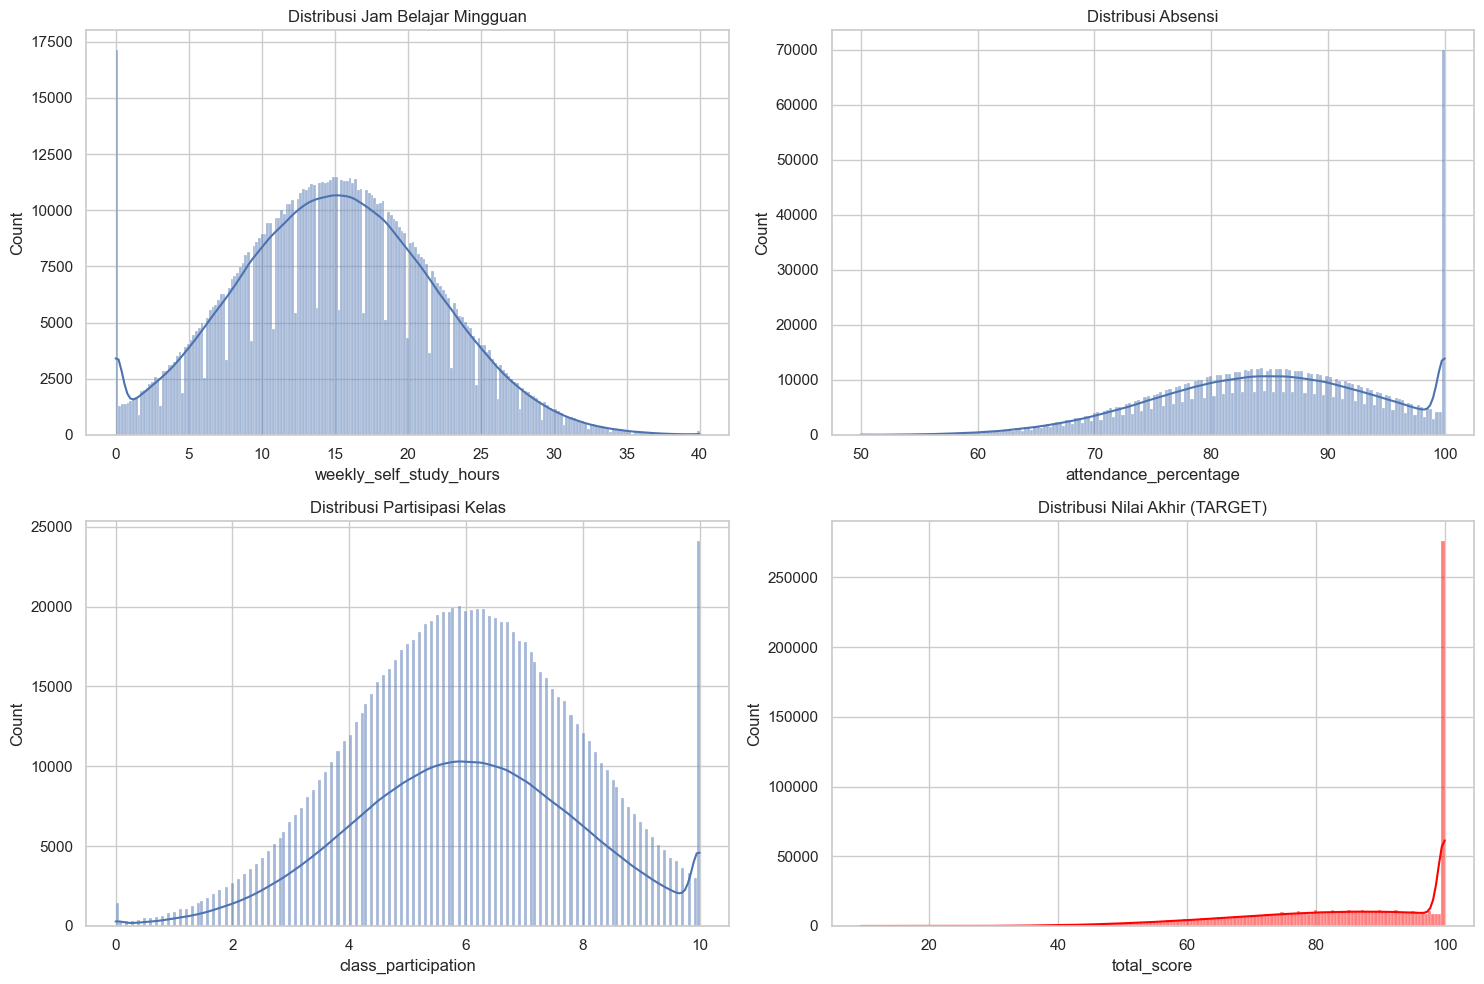

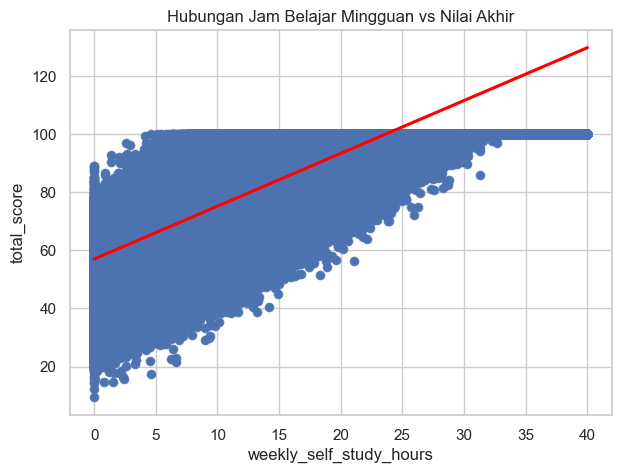

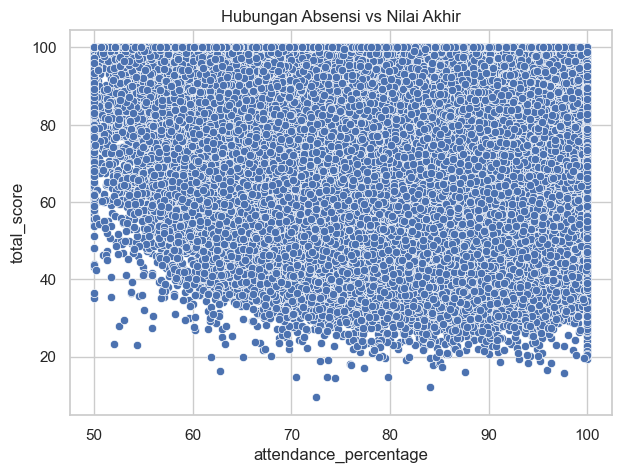

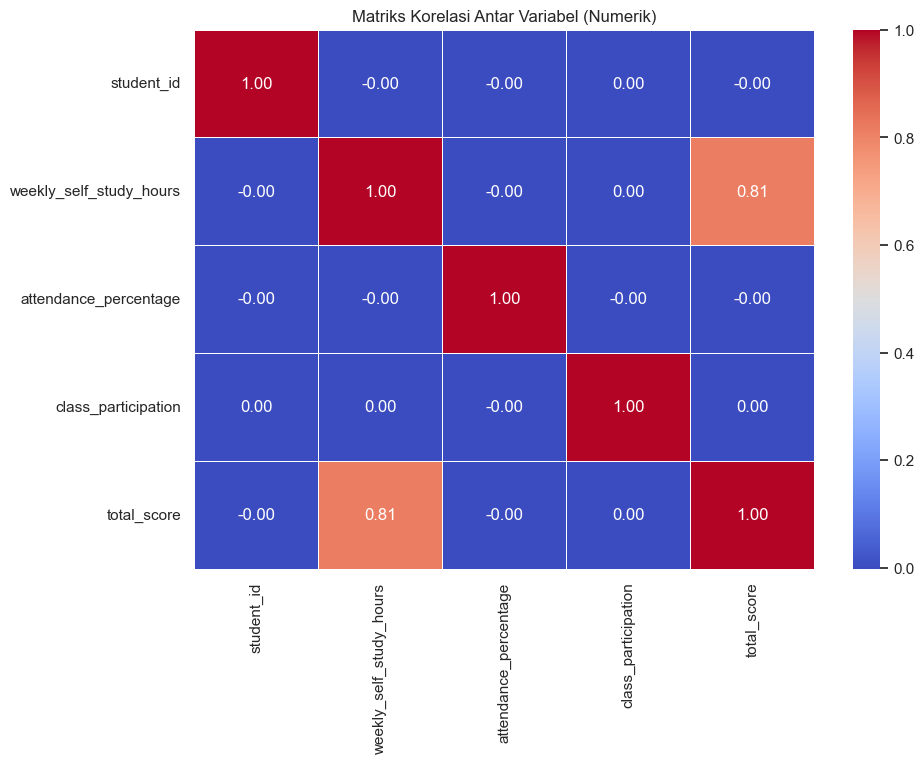

In [ ]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_cleaned['weekly_self_study_hours'], kde=True, ax=axes[0, 0]).set_title('Distribusi Jam Belajar Mingguan')
sns.histplot(df_cleaned['attendance_percentage'], kde=True, ax=axes[0, 1]).set_title('Distribusi Absensi')
sns.histplot(df_cleaned['class_participation'], kde=True, ax=axes[1, 0]).set_title('Distribusi Partisipasi Kelas')
sns.histplot(df_cleaned['total_score'], kde=True, ax=axes[1, 1], color='red').set_title('Distribusi Nilai Akhir (TARGET)')
plt.tight_layout()
plt.show()
plt.figure(figsize=(7, 5))

sns.scatterplot(x='weekly_self_study_hours', y='total_score', data=df_cleaned)
sns.regplot(x='weekly_self_study_hours', y='total_score', data=df_cleaned, line_kws={"color": "red"})
plt.title('Hubungan Jam Belajar Mingguan vs Nilai Akhir')
plt.show()
plt.figure(figsize=(7, 5))

sns.scatterplot(x='attendance_percentage', y='total_score', data=df_cleaned)
plt.title('Hubungan Absensi vs Nilai Akhir')
plt.show()
plt.figure(figsize=(10, 7))

sns.heatmap(df_cleaned.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi Antar Variabel (Numerik)')
plt.show()

In [19]:
features = ['weekly_self_study_hours', 'attendance_percentage', 'class_participation'] 

target = 'total_score'

X = df_cleaned[features]
y = df_cleaned[target]

print("\nFitur (X) yang digunakan untuk model:")
print(X.columns.tolist())
print("\nTarget (y) yang akan diprediksi:")
print(y.name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData latih (train): {X_train.shape[0]} baris")
print(f"Data uji (test): {X_test.shape[0]} baris")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing selesai. Data siap untuk model.")


Fitur (X) yang digunakan untuk model:
['weekly_self_study_hours', 'attendance_percentage', 'class_participation']

Target (y) yang akan diprediksi:
total_score

Data latih (train): 800000 baris
Data uji (test): 200000 baris
Preprocessing selesai. Data siap untuk model.


In [21]:
print("\n--- Memulai Pelatihan Model ---")

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Linear Regression Selesai.")

# Model 2: Random Forest Regressor
# Reduce memory footprint: fewer trees, single job, limit depth and sample fraction.
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1, max_depth=12, max_samples=0.5)
try:
	rf_model.fit(X_train_scaled, y_train)
	print("Random Forest Selesai.")
except MemoryError:
	print("MemoryError saat melatih Random Forest — mencoba ulang dengan subset data dan parameter yang lebih kecil.")
	# fallback: use a smaller subset and fewer trees to avoid memory issues
	subset_size = min(100_000, X_train_scaled.shape[0])
	rf_model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=1, max_depth=10)
	rf_model.fit(X_train_scaled[:subset_size], y_train.iloc[:subset_size])
	print(f"Random Forest selesai pada subset {subset_size} baris.")



--- Memulai Pelatihan Model ---
Linear Regression Selesai.
Random Forest Selesai.


In [22]:
print("\n--- Memulai Evaluasi Model ---")
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"--- Hasil {model_name} ---")
    print(f"R-squared (R²): {r2:.3f}")
    print(f"MAE: {mae:.3f}")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


--- Memulai Evaluasi Model ---
--- Hasil Linear Regression ---
R-squared (R²): 0.660
MAE: 7.161
--- Hasil Random Forest ---
R-squared (R²): 0.717
MAE: 6.106


In [24]:
print("\n--- Interpretasi Model (HASIL BARU) ---")

# A. Koefisien Linear Regression
lr_coeffs = pd.DataFrame(lr_model.coef_, index=features, columns=['Coefficient'])
print("Koefisien Linear Regression:")
print(lr_coeffs.sort_values(by='Coefficient', ascending=False))

# B. Feature Importance Random Forest
rf_importances = pd.DataFrame(rf_model.feature_importances_, index=features, columns=['Importance'])
print("\nFeature Importance Random Forest:")
print(rf_importances.sort_values(by='Importance', ascending=False))


--- Interpretasi Model (HASIL BARU) ---
Koefisien Linear Regression:
                         Coefficient
weekly_self_study_hours    12.535226
attendance_percentage       0.003785
class_participation        -0.005390

Feature Importance Random Forest:
                         Importance
weekly_self_study_hours    0.985732
attendance_percentage      0.008132
class_participation        0.006136
